## Part 1 - Imports and connection to Drive

In [ ]:
# Connection to Drive 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
% cd "/path/to/folder/notebooks"

In [3]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import CustomDataSet as dt 

import cv2

##Part 2 - Loading and fine-tuning ResNet18

In [ ]:
batch_size = 5 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
# Dataset (training + validation)
data_train = dt.DatasetTrain("../data/train")
data_test = dt.DatasetTrain("../data/test")

In [ ]:
# Processing training dataset
train_loader = torch.utils.data.DataLoader(dataset=data_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Processing validation dataset
test_loader = torch.utils.data.DataLoader(dataset=data_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [ ]:
# Load ResNet18
resnet = torchvision.models.resnet18(pretrained=True)

In [ ]:
# Fine-tuning preparation
for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, 2)

In [ ]:
# Load model if existent
try:
  resnet.load_state_dict(torch.load('../models/model.ckpt'))
  print("Existent ResNet18 loaded")
except:
  print("No existent ResNet18 found")

In [4]:
def validation(test_loader, model, localization=None, nb_img=None):
    # Test the model
    model.eval()
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct, total = 0, 0
        image, label = 0, 0
        img_tab, label_tab = [], []
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if localization:
                label = labels[0]
                image = inputs[0]
                img_tab.append(image)
                label_tab.append(label)

                if len(img_tab) == nb_img:
                    break
    if localization:
        # return (image, label, correct, total)
        return (img_tab, label_tab, correct, total)

    return (correct, total)

In [ ]:
# Hyper-parameters
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)  
num_epochs = 10

In [ ]:
# Training 
num_batch = len(train_loader) #600 batches each containing 100 inputs = 60000 inputs
num_training_data = len(data_train)
training_loss_v = []
valid_acc_v = []
for epoch in range(num_epochs):
    loss_tot = 0
    resnet.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad() #set gradients of all parameters to zero
        loss.backward()
        optimizer.step()
        
        # Compute loss
        loss_tot += loss.item()
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Batch Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, num_batch, loss.item()/len(labels)))
    
    # Compute validation
    (correct, total) = validation(test_loader, resnet)
    print ('Epoch [{}/{}], Training Loss: {:.4f}, Valid Acc: {} %'.format(epoch+1, num_epochs, loss_tot/num_training_data, 100 * correct / total))

    # Retrieve loss and validation data
    training_loss_v.append(loss_tot/num_training_data)
    valid_acc_v.append(correct / total)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Step [10/577], Batch Loss: 0.1922
Epoch [1/10], Step [20/577], Batch Loss: 0.1401
Epoch [1/10], Step [30/577], Batch Loss: 0.0963
Epoch [1/10], Step [40/577], Batch Loss: 0.1624
Epoch [1/10], Step [50/577], Batch Loss: 0.1403
Epoch [1/10], Step [60/577], Batch Loss: 0.1466
Epoch [1/10], Step [70/577], Batch Loss: 0.2479
Epoch [1/10], Step [80/577], Batch Loss: 0.1191
Epoch [1/10], Step [90/577], Batch Loss: 0.1134
Epoch [1/10], Step [100/577], Batch Loss: 0.1190
Epoch [1/10], Step [110/577], Batch Loss: 0.1187
Epoch [1/10], Step [120/577], Batch Loss: 0.1120
Epoch [1/10], Step [130/577], Batch Loss: 0.1227
Epoch [1/10], Step [140/577], Batch Loss: 0.1361
Epoch [1/10], Step [150/577], Batch Loss: 0.1636
Epoch [1/10], Step [160/577], Batch Loss: 0.1150
Epoch [1/10], Step [170/577], Batch Loss: 0.1311
Epoch [1/10], Step [180/577], Batch Loss: 0.1105
Epoch [1/10], Step [190/577], Batch Loss: 0.1522
Epoch [1/10], Step [200/577], Batch Loss: 0.1104
Epoch [1/10], Step [210/577],

In [ ]:
# Save model
numero = 3
torch.save(resnet.state_dict(), '../models/model_0{numero}.ckpt')

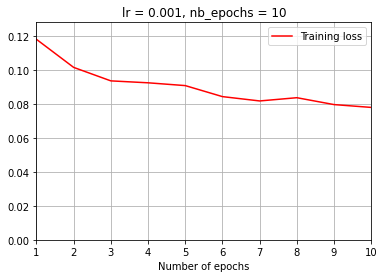

In [ ]:
# Plot training loss evolution
plt.figure(2)
plt.clf()
x_tab = list(range(1, num_epochs+1))
y_tab = np.array(training_loss_v)
plt.plot(x_tab, y_tab,'r',label='Training loss')
plt.legend()
plt.xlim((1, num_epochs))
plt.ylim((0, max(y_tab)+0.01))
plt.grid()
plt.xlabel("Number of epochs")
plt.title(f"lr = {learning_rate}, nb_epochs = {num_epochs}")
plt.savefig(f"../report/training_loss_0{numero}")

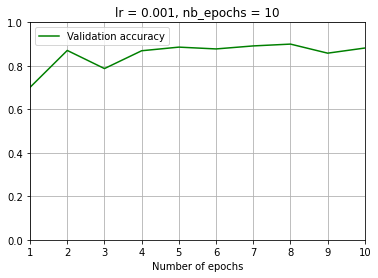

In [ ]:
# Plot validation accuracy evolution
plt.figure(3)
plt.clf()
plt.plot(tab, np.array(valid_acc_v),'g',label='Validation accuracy')
plt.legend()
plt.xlim((1, num_epochs))
plt.ylim((0, 1))
plt.grid()
plt.xlabel("Number of epochs")
plt.title(f"lr = {learning_rate}, nb_epochs = {num_epochs}")
plt.savefig(f"../report/validation_accuracy_0{numero}")

## Part 3 - Detection of Asian hornets

In [44]:
#
(inputs, labels) = iter(test_loader).next()
outputs = resnet(inputs.to(device))
_, predicted = torch.max(outputs.data, 1)

<Figure size 432x288 with 0 Axes>

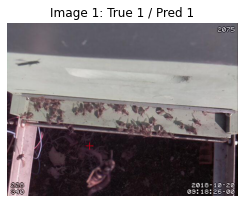

In [45]:
# Plot predicted results
plt.figure(4)
plt.clf()
N_rows = 2
N_cols = 4
fig = plt.figure(figsize=(10*N_rows, 7))

N = len(inputs)
for idx in range(N):
      image = inputs[idx,:]
      fig.add_subplot(N_rows, N_cols, idx+1)
      plt.imshow(transforms.ToPILImage()(image))
      plt.axis('off')
      plt.title('Image {}: True {} / Pred {}'.format(idx+1, labels[idx], predicted[idx]))
plt.savefig("../report/comparison_label_prediction")

## Part 4 - Localization of Asian hornets

In [5]:
batch_size = 1
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
num_epochs = 20

In [6]:
# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

Device: 'cpu'


In [9]:
# Dataset
test_loader = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size=batch_size,
                                          shuffle=True)

In [10]:
# Load model
resnet = torchvision.models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, 2)

resnet.to(device=device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

resnet.load_state_dict(torch.load('../models/model_02.ckpt'))

<All keys matched successfully>

In [11]:
a = []

def hook(module, input, output):
    for i in range(len(output)):
        a.append(output)
    # print("input", input)
    # print("output", output)

In [12]:
# Get output of any layer while doing a single forward pass
resnet.layer4[1].bn2.register_forward_hook(hook)
weight = resnet.layer4[1].bn2.weight.cpu().numpy()

In [42]:
# Extract images, associated labels
(img_tab, label_tab, correct, total) = validation(test_loader, resnet, localization=4, nb_img=10)
print("Validation accuracy: {}% (nb_img = {})".format(100*correct/total, total))

Validation accuracy: 20.0% (nb_img = 10)


Image size: (640, 480)
Label: '0'
Image size: (640, 480)
Label: '0'
Image size: (640, 480)
Label: '0'
Image size: (640, 480)
Label: '0'
Image size: (640, 480)
Label: '0'
Image size: (640, 480)
Label: '0'
Image size: (640, 480)
Label: '1'
Image size: (640, 480)
Label: '0'
Image size: (640, 480)
Label: '1'
Image size: (640, 480)
Label: '0'


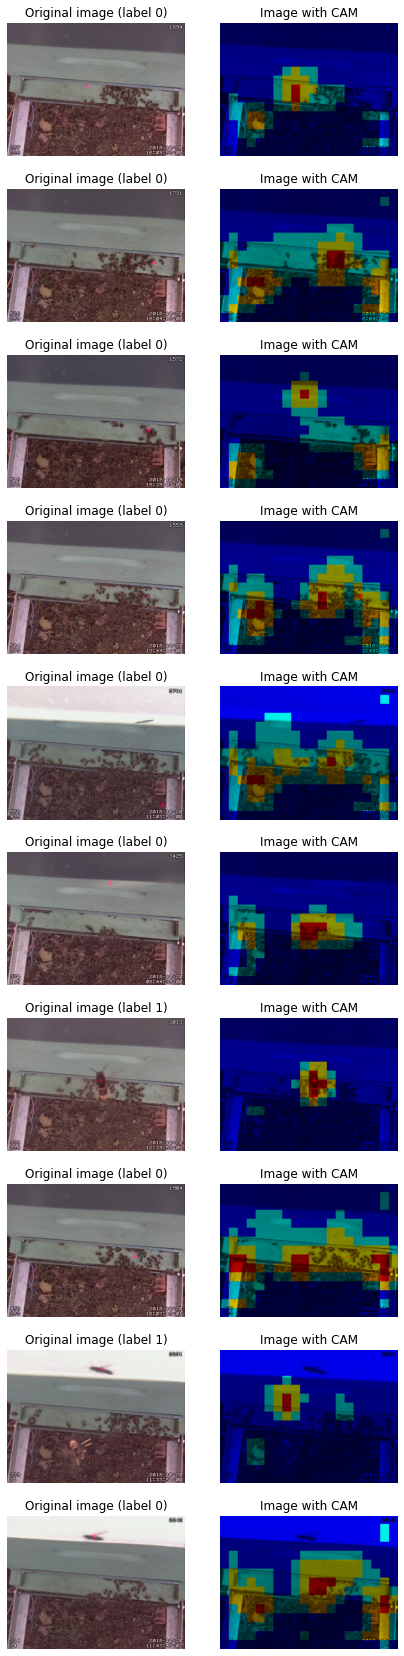

In [43]:
N_rows, N_cols = len(img_tab), 2
fig, ax = plt.subplots(N_rows, N_cols, figsize=(7, 15*N_cols))
for idx in range(len(img_tab)):
    img = img_tab[idx]
    label = label_tab[idx]

    # Convert image to PIL image
    img = transforms.ToPILImage()(img)
    img_size = img.size
    print(f"Image size: {img_size}")

    # Output
    output = a[idx][0].cpu().numpy()

    # Compute mask/filter
    mat = np.zeros((15,20))
    for i in range(512):
        mat += weight[i]*output[i]
    mat /= 512
    min_ = np.amin(mat)
    mat = mat - min_
    max_ = np.amax(mat)
    mat /= max_

    # Create mask/filter
    im = cv2.resize(mat, dsize=(640, 480), interpolation=cv2.INTER_AREA).round(1)
    tmp = np.zeros((480, 640, 3))
    tmp[:,:,0] = (im>=0.6)
    tmp[:,:,1] = ((0.4 <=im) * (im <=0.8))
    tmp[:,:,2] = (im <= 0.5)
    img_CAM = img * tmp
    img_CAM /= 255
    print(f"Label: '{label}'")

    # Display original image
    ax[idx,0].imshow(img)
    ax[idx,0].axis('off')
    ax[idx,0].set_title(f"Original image (label {label})")

    # Display image with CAM
    ax[idx,1].imshow(img_CAM)
    ax[idx,1].axis('off')
    ax[idx,1].set_title("Image with CAM")
